In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
url = 'first_week.csv'
df_start = pd.read_csv(url)

In [61]:
df_prev = df_start.copy()
df_prev['stop_sequence_sched'] = df_prev['stop_sequence_sched'] + 1

In [163]:
df_merged = df_start.merge(
    df_prev[['trip_id', 'stop_sequence_sched', 'departure_time_real', 'shape_dist_traveled']],
    on=['trip_id', 'stop_sequence_sched'],
    how='left',
    suffixes=('', '_prev')
)

In [165]:
print(len(df_merged), len(df_start))


128604 33610


In [169]:
from datetime import datetime
df_merged['arrival_time_real'] = pd.to_datetime(df_merged['arrival_time_real'], format='%Y-%m-%d %H:%M:%S')
df_merged['departure_time_real_prev'] = pd.to_datetime(df_merged['departure_time_real_prev'], format='%Y-%m-%d %H:%M:%S')

In [171]:
df_merged['time_diff_sec'] = (df_merged['arrival_time_real'] - df_merged['departure_time_real_prev']).dt.total_seconds()
df_merged["distance_diff_meters"]=(df_merged['shape_dist_traveled'] - df_merged['shape_dist_traveled_prev'])

In [175]:
df = df_merged[abs(df["time_diff_sec"]) < 1000]
len(df)

32189

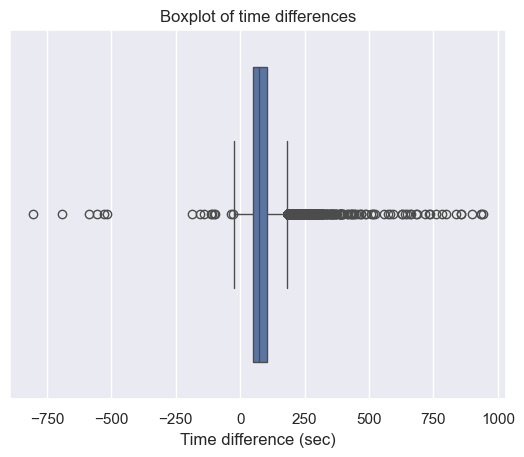

400

In [177]:
#sns.set()
#sns.histplot(x=df['time_diff_sec'])
sns.boxplot(x=df['time_diff_sec'].dropna())
plt.xlabel('Time difference (sec)')
plt.title('Boxplot of time differences')
plt.show()
len(df['time_diff_sec'].unique())

In [179]:
df["speed_km_h"]=(df["distance_diff_meters"]/df['time_diff_sec'])*3.6
#the speed for a line segment is now always safed in point that is after the specific line segment. speed 1->2 is safed in point 2. 

C:\Users\Johanna\AppData\Local\Temp\ipykernel_19984\3786601504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["speed_km_h"]=(df["distance_diff_meters"]/df['time_diff_sec'])*3.6


In [236]:
df.loc[df['stop_headsign'] == "Ruddammen", 'destination'] = "Ruddammen"
df.loc[df['stop_headsign'] == "Hornsberg", 'destination'] = "Hornsberg"
df.loc[df['stop_headsign'] == "Henriksdalsberget", 'destination'] = "Henriksdalsberget"
df.loc[df['stop_headsign'] == "Karolinska institutet", 'destination'] = "Karolinska institutet"
df.loc[df['stop_headsign'] == "Hornsberg via Södersjukhuset", 'destination'] = "Hornsberg"
df.loc[df['stop_headsign'] == "Sickla udde", 'destination'] = "Sickla udde"
df.loc[df['stop_headsign'] == "Sickla udde via Södersjukhuset", 'destination'] = "Sickla udde"

C:\Users\Johanna\AppData\Local\Temp\ipykernel_19984\2109664163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['stop_headsign'] == "Ruddammen", 'destination'] = "Ruddammen"


[61 53 74]
61
Hornsberg
[ 8 19 20 21 22 23 24 25 26 27 28 29  9 10 11 12 13 14 15 16 17 18  2  3
  4  5  6  7]
61
Ruddammen
[ 8 19 20 21 22 23 24 25 26 27 28 29  9 10 11 12 13 14 15 16 17 18  2  3
  4  5  6  7]


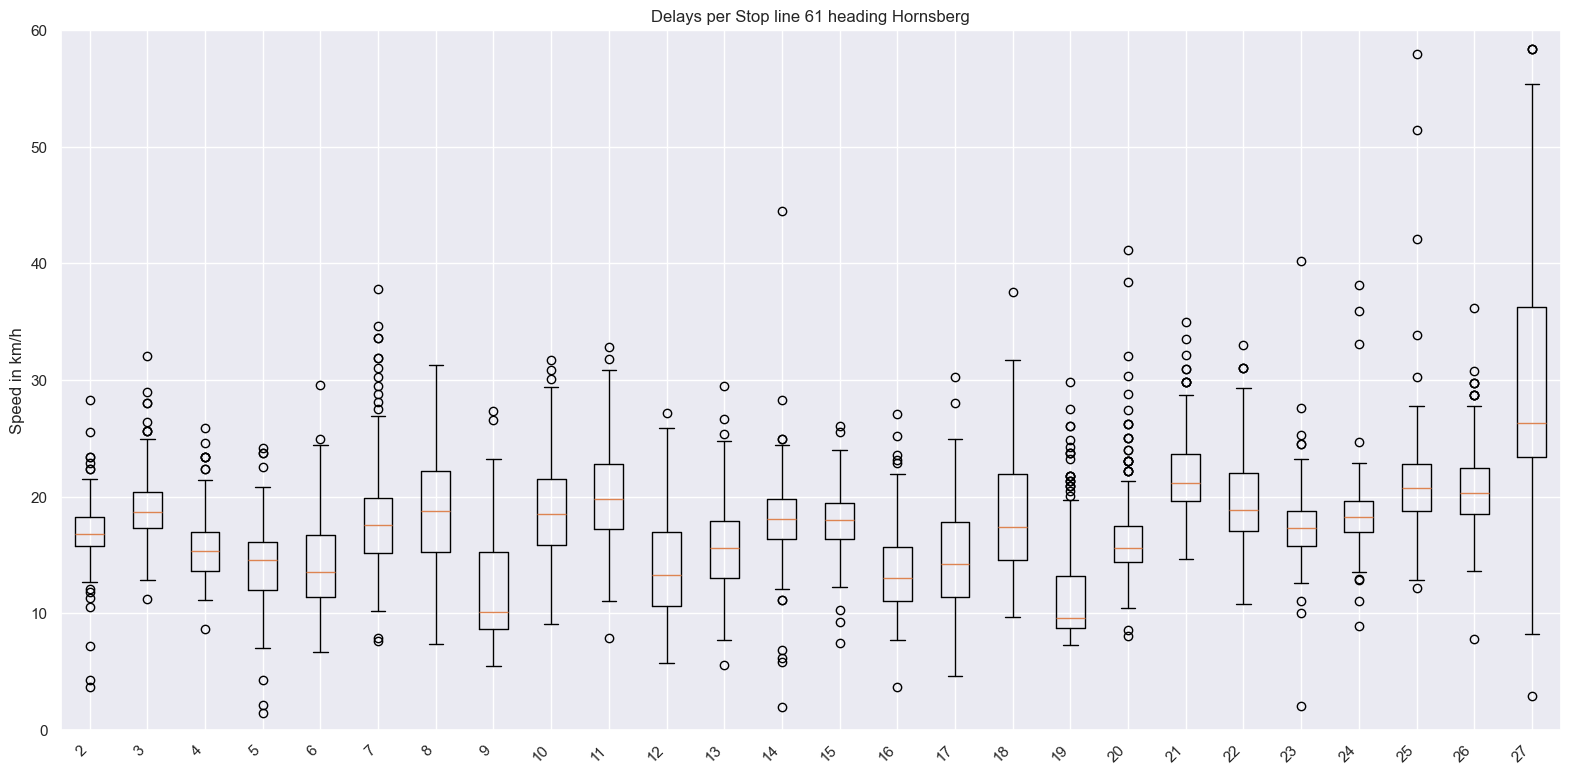

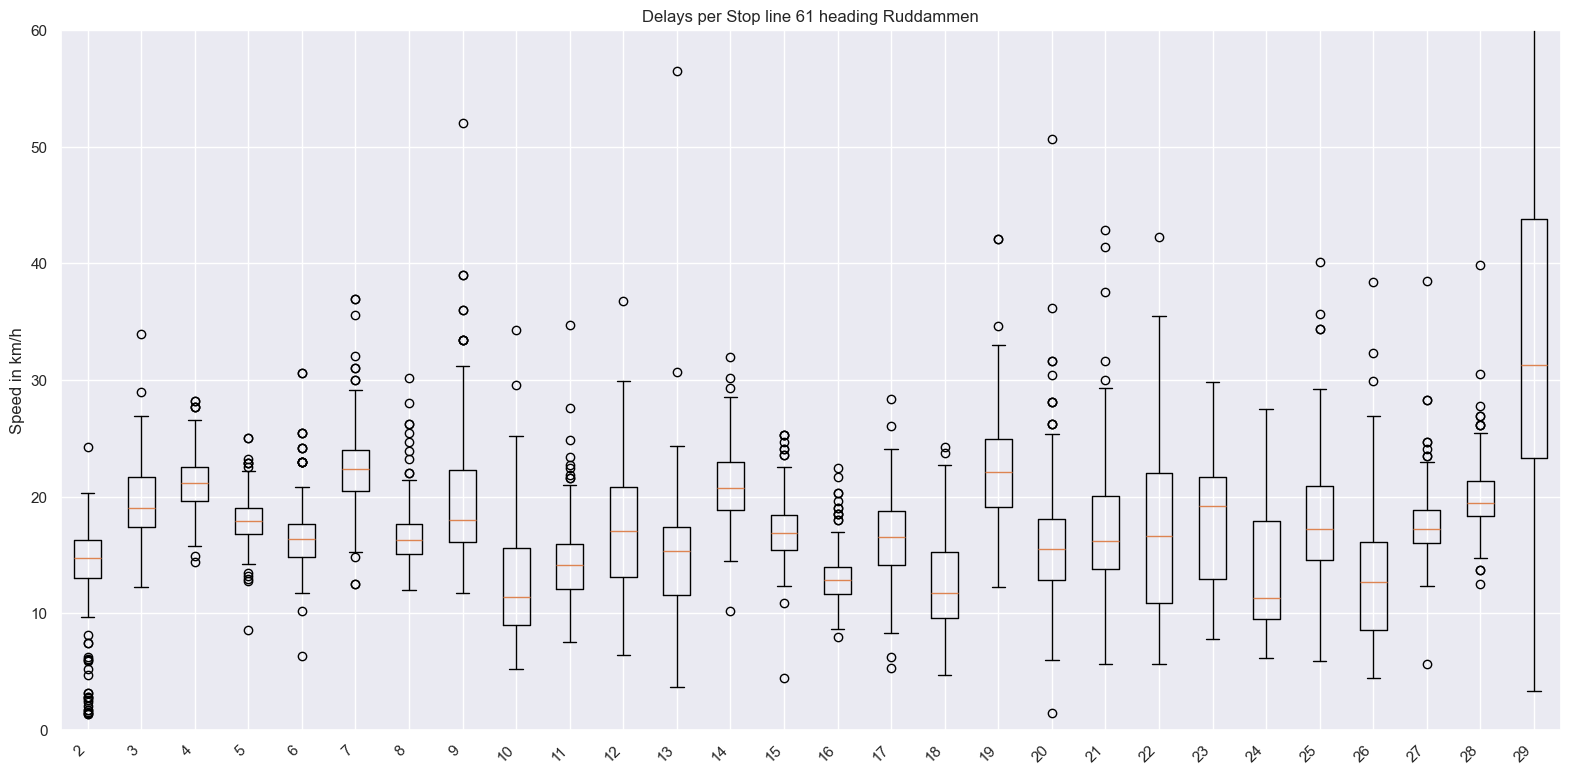

In [267]:
print(df['route_short_name'].unique())
performances_per_lines = {}
#line="61"
for line in [61]:#df['route_short_name'].unique()
    for dest in df['destination'].unique():
        if df.loc[(df['route_short_name']==line)&(df['destination']==dest)].empty :
            continue
        d=[]
        labels = []
        print(line)
        print(dest)
        print(df.loc[df['route_short_name']==line]['stop_sequence_sched'].unique())
        performances_per_lines[str(line) + dest] = df.loc[(df['route_short_name']==line) & (df['destination']==dest)]
        for stop in sorted(df.loc[(df['route_short_name']==line) & (df['destination']==dest)]['stop_sequence_sched'].unique()):
          d.append(df.loc[(df['stop_sequence_sched']==stop) & (df['route_short_name']==line) & (df['destination']==dest) ]['speed_km_h'].values)
          nom = df.loc[(df['stop_sequence_sched']==stop) & (df['route_short_name']==line) &(df['destination']==dest)]['stop_name'].unique()
          labels.append(str(stop))
    
        fig = plt.figure(figsize =(15, 7))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(d)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        plt.ylim(0,60)
        ax.set_ylabel("Speed in km/h")
        ax.set_title(f"Delays per Stop line {line} heading {dest}")
# Customize the boxplot appearance

plt.show()

In [287]:
df_79peak = df[
    (df['arrival_time_real'].dt.hour >= 7) &
    (df['arrival_time_real'].dt.hour <9)
]

In [295]:
df_medianspeed=pd.DataFrame(columns=['route_short_name', 'destination', 'stop_sequence_sched', 'median_speed'])
for line in [61]:#df['route_short_name'].unique():
  for dest in df['destination'].unique():
    if df.loc[(df['route_short_name']==line)&(df['destination']==dest)].empty :
      continue
    d=[]
    for stop in sorted(df.loc[(df['route_short_name']==line) & (df['destination']==dest)]['stop_sequence_sched'].unique()):
        d=df.loc[(df['stop_sequence_sched']==stop) & (df['route_short_name']==line) & (df['destination']==dest) ]['speed_km_h'].values
        median = pd.Series(d).median()
        print(median)
        df_medianspeed.loc[len(df_medianspeed)] = [line, dest, stop, median]
df_medianspeed.head()
len(df_medianspeed)


16.7833125
18.705
15.365250000000005
14.554838709677416
13.511872340425539
17.538782608695644
18.751015384615396
10.111695652173909
18.51175384615386
19.753846153846155
13.258536585365855
15.582857142857142
18.052173913043458
18.021176470588266
13.054196891191701
14.181721518987343
17.381414634146335
9.574348623853222
15.57632432432434
21.157578947368414
18.85371428571433
17.32094117647053
18.232695652173916
20.737611940298546
20.28292682926829
26.27999999999992
14.742857142857142
19.053658536585367
21.1629375
17.929227272727275
16.380000000000013
22.339255813953482
16.268400000000003
18.009692307692298
11.431200000000004
14.134444444444439
17.072357142857154
15.340304347826097
20.705647058823526
16.874399999999987
12.834367346938814
16.560935064935038
11.741142857142856
22.1058556701031
15.502040816326529
16.219945945945938
16.654368771526993
19.153259606373013
11.274857142857156
17.19449999999996
12.710205357142874
17.19192857142859
19.485957446808552
31.30559999999987


54

In [297]:
#df_medianspeed_79peak=pd.DataFrame(columns=['route_short_name', 'stop_headsign', 'stop_sequence_sched', 'median_speed'])
for line in [61]:#df_79peak['route_short_name'].unique():
  for dest in df_79peak['destination'].unique():
    if df_79peak.loc[(df_79peak['route_short_name']==line)&(df_79peak['destination']==dest)].empty :
      continue
    d=[]
    for stop in sorted(df_79peak.loc[(df_79peak['route_short_name']==line) & (df_79peak['destination']==dest)]['stop_sequence_sched'].unique()):
        d=df_79peak.loc[(df_79peak['stop_sequence_sched']==stop) & (df_79peak['route_short_name']==line) & (df_79peak['destination']==dest) ]['speed_km_h'].values
        median_79peak = pd.Series(d).median()
        print(median_79peak)
        df_medianspeed.loc[(df_medianspeed['stop_sequence_sched']==stop) & (df_medianspeed['route_short_name']==line) & (df_medianspeed['destination']==dest), "median_speed_79peak"] = median_79peak
print(len(df_medianspeed))
df_medianspeed.head()

16.15327408412483
18.323265306122448
14.048228571428576
13.672727272727268
14.433136363636372
16.35372972972972
18.191283582089564
9.541543235851037
19.099428571428586
18.676363636363636
11.817391304347826
15.582857142857142
17.543661971830964
16.903424657534273
12.821762405469793
13.029156997971604
15.965231789737166
9.532418918918928
14.777538461538477
21.157578947368414
18.85371428571433
17.667359999999945
17.972228571428573
20.737611940298546
18.900000000000002
26.27999999999992
14.835925394548063
18.826829268292684
20.83735384615385
17.532964563526363
15.288000000000011
20.88234782608695
15.495119738751818
18.009692307692298
9.22297513013303
13.51196595181729
15.672983606557388
14.331323505154646
20.50655429864253
16.070857142857133
12.839715000000037
15.457440493682014
10.578653465346534
20.421600000000005
14.332075471698113
16.787897887323936
12.216432806324121
12.818401678321681
10.294434782608707
15.407258064516093
10.413956043956059
17.19192857142859
19.485957446808552
42.142

,route_short_name,destination,stop_sequence_sched,median_speed,median_speed_79peak
0,61,Hornsberg,2,16.783313,16.153274
1,61,Hornsberg,3,18.705000,18.323265
2,61,Hornsberg,4,15.365250,14.048229
3,61,Hornsberg,5,14.554839,13.672727
4,61,Hornsberg,6,13.511872,14.433136


In [301]:
print(len(df_medianspeed))
df_medianspeed[['route_short_name', 'destination', 'stop_sequence_sched']].duplicated().sum()


54


0

In [309]:
df_coords = df[['route_short_name', 'destination', 'stop_sequence_sched', 'stop_lat', 'stop_lon']].drop_duplicates()
print(len(df_coords))
#dupes = df_coords[df_coords.duplicated(subset=['route_short_name', 'stop_headsign', 'stop_sequence_sched'], keep=False)]
#dupes = dupes.sort_values(['route_short_name', 'stop_headsign', 'stop_sequence_sched'])

#dupes[['route_short_name', 'stop_headsign', 'stop_sequence_sched', 'stop_lat', 'stop_lon']]

160


In [313]:
df_medianspeed_withcoord = df_medianspeed.merge(
    df_coords,
    on=['route_short_name', 'destination', 'stop_sequence_sched'],
    how='left'
)
len(df_medianspeed_withcoord)

54

In [315]:
df_medianspeed_withcoord
#I want to join that to what I have in ArcGIS 

,route_short_name,destination,stop_sequence_sched,median_speed,median_speed_79peak,stop_lat,stop_lon
0,61,Hornsberg,2,16.783313,16.153274,59.351849,18.063546
1,61,Hornsberg,3,18.705000,18.323265,59.349887,18.064317
2,61,Hornsberg,4,15.365250,14.048229,59.348822,18.064188
3,61,Hornsberg,5,14.554839,13.672727,59.346567,18.065625
4,61,Hornsberg,6,13.511872,14.433136,59.345139,18.059928
5,61,Hornsberg,7,17.538783,16.353730,59.343836,18.054827
6,61,Hornsberg,8,18.751015,18.191284,59.342516,18.049194
7,61,Hornsberg,9,10.111696,9.541543,59.341286,18.045989
8,61,Hornsberg,10,18.511754,19.099429,59.338674,18.048542
9,61,Hornsberg,11,19.753846,18.676364,59.332241,18.044909
